In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib
import os
from simple_dispatch import bidStack
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
colorset = ['#882255','#88CCEE','#332288', '#DDCC77',   '#CC6677','#44AA99', '#117733','#AA4499','#999933']
gds = {}
gds[2019] = pickle.load(open('Data/generator_data_short_WECC_2019.obj', 'rb'))
gds[2020] = pickle.load(open('Data/generator_data_short_WECC_2020.obj', 'rb'))

parent_dir = os.path.dirname(os.getcwd())

path_string = parent_dir + '/Data/MEF/'

 

In [2]:
def results_gperkwh_fxn(numev_set, path_string, run_number, result_dates, path_string_mef=None, current_year = None, group_num=None):
    
    #choose plotting timeframe, result date, run number, and number of EVs
    if current_year == 2030:
        #use 2020 for uncontrolled data
        dpdf_year = '2020'
        #get reference baseline projected 2030 demand
        result_date_2030 = '20220522'
        reference_df = pd.read_csv('Results/' +'_dpdf_'+result_date_2030 + '.csv')

    #default = 2020
    else:
        dpdf_year = '2020'
        reference_df = pd.read_csv('Results/2020_dpdf_20220522.csv')

    time_period_string = '2020-01-01_to_2020-01-31'
    if len(result_dates[0])>1:
        result_date = result_dates[0]
    else:
        result_date = result_dates

    #define dataframe names
    df_total_uncontrolled = {}; df_uncontrolled_dpdf = {}
    df_total_controlled = {'varying':{'access':{}, 'plugged':{}}}
    df_controlled_dpdf = {'varying':{'access':{}, 'plugged':{}}}

    for num_evs in numev_set:
        #save uncontrolled demand data in df
        if path_string_mef is None:
            df_total_uncontrolled[num_evs] = pd.read_csv(path_string + str(num_evs)+'EVs_added/Uncontrolled/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
        else:
            df_total_uncontrolled[num_evs] = pd.read_csv(path_string_mef + str(num_evs)+'EVs_added/Uncontrolled/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
        
        df_total_uncontrolled[num_evs].datetime = pd.to_datetime(df_total_uncontrolled[num_evs].datetime)
        df_uncontrolled_dpdf[num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Uncontrolled/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+ '_dpdf_'+result_date+'.csv')
        df_uncontrolled_dpdf[num_evs].datetime = pd.to_datetime(df_uncontrolled_dpdf[num_evs].datetime)
        for signal1 in ['varying']:
            for signal2 in ['access']:
                df_total_controlled[signal1][signal2][num_evs] = pd.read_csv(path_string +str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/demand_run'+run_number+'_'+time_period_string+'_'+result_date+'.csv', index_col=0)
                df_total_controlled[signal1][signal2][num_evs].datetime = pd.to_datetime(df_total_controlled[signal1][signal2][num_evs].datetime)
                df_controlled_dpdf[signal1][signal2][num_evs] = pd.read_csv(path_string+str(num_evs)+'EVs_added/Controlled_'+str(signal1)+'_allaccess_'+str(signal2)+'_series/results_'+dpdf_year+'_run'+run_number+'_'+time_period_string+'_' + str(group_num)+ '_dpdf_'+result_date+'.csv')
                df_controlled_dpdf[signal1][signal2][num_evs].datetime = pd.to_datetime(df_controlled_dpdf[signal1][signal2][num_evs].datetime)
            
    num_evs = numev_set[0]
    #finds dates to plot
    signal1 = 'varying'
    signal2 = 'access'
    dpdf_inds = df_uncontrolled_dpdf[num_evs][df_uncontrolled_dpdf[num_evs].datetime.dt.date.isin(df_total_controlled[signal1][signal2][num_evs].datetime.dt.date.unique())].index

    #initialize results DataFrame
    results_gperkwh = pd.DataFrame(index=numev_set, columns=['uncontrolled', 'varying_access', 'varying_plugged'])

    #loop to get results for each number of added EVs
    for i in results_gperkwh.index:
        num_evs = int(i)
        #find total change in CO2 emissions from reference
        delta_co2 = df_uncontrolled_dpdf[num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()

        #find total change in demand from reference
        delta_demand = df_uncontrolled_dpdf[num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()
        
        results_gperkwh.loc[i, 'uncontrolled'] = delta_co2/delta_demand
        
        for signal1 in ['varying']:
            signal2_set = ['access']

            for signal2 in signal2_set:
                delta_co2 = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'co2_tot'].sum() - reference_df.loc[dpdf_inds, 'co2_tot'].sum()
                delta_demand = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds, 'demand'].sum() - reference_df.loc[dpdf_inds, 'demand'].sum()
                results_gperkwh.loc[i, signal1+'_'+signal2] = delta_co2/delta_demand

    return results_gperkwh, df_controlled_dpdf, df_total_controlled, df_total_uncontrolled

In [3]:
def emissions_mef_plot(df_controlled_dpdf, dpdf_inds, num_evs, save_str, axes=None, group_num=0):

    hr_start = 42

    num_hours=5
    inds3 = np.arange(hr_start, hr_start+num_hours)

    signal1 = 'varying'
    signal2 = 'access'

    #get mef values
    mef_varying = df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds].co2_marg.values[inds3]
    markers = ['o', 'P', '*', 'X', 'd']
    axes.plot(df_controlled_dpdf[signal1][signal2][num_evs].loc[dpdf_inds].datetime.values[inds3], mef_varying, color=colorset[group_num], marker= markers[group_num] , markersize=11, label='Group ' + str(group_num+1), linewidth=2)

  
    axes.set_yticklabels(np.arange(0, 1201, 200), fontsize=18)
    axes.set_ylabel('CO$_2$ Emissions [kg/MWh]', fontsize=18)
    axes.set_xlabel('Hour', fontsize=18)
    axes.set_ylim([0, 1350])
    axes.set_yticks(np.arange(0, 1202, 200))
    
    axes.set_xticks(np.linspace(axes.get_xticks().min(), axes.get_xticks().max(),num_hours%24))
    axes.set_xticklabels(np.arange(num_hours%24)+hr_start, fontsize=18)


    plt.savefig(save_str + '.pdf', bbox_inches='tight')
    return axes

In [4]:
def emissions_demand_plot(df_controlled_dpdf, df_total_uncontrolled, dpdf_inds, num_evs, save_str, axes, group_num=None):
    signal1a = 'varying'
    signal2a = 'access'

    #define indices
    hr_start = 7
    hr_start = 42
    num_hours = 4
    num_hours=5
    inds3 = np.arange(hr_start, hr_start+num_hours)

    markers = ['o', 'P', '*', 'X', 'd']
    axes.plot(df_controlled_dpdf[signal1a][signal2a][num_evs].loc[dpdf_inds].datetime.values[inds3], df_controlled_dpdf[signal1a][signal2a][num_evs].loc[dpdf_inds].demand.values[inds3], color=colorset[group_num], marker= markers[group_num] , markersize=11, label='Group ' + str(group_num+1), linewidth=2)
    axes.set_ylim([40000, 50000])
    axes.set_yticks(np.arange(40000, 50001, 2000))
    axes.set_yticklabels(np.arange(40, 51, 2), fontsize=16)
    axes.set_ylabel('Fossil Demand [GW]', fontsize=16)
    axes.set_xticks(np.linspace(axes.get_xticks().min(), axes.get_xticks().max(),num_hours%24))
    axes.set_xticklabels(np.arange(num_hours%24)+hr_start%24, fontsize=16)
    axes.legend(loc='lower left', fontsize=16, ncols=2)
    axes.tick_params(axis='x', which='major', pad=10)

    plt.tight_layout()
    plt.savefig(save_str + '.pdf', bbox_inches='tight')
   
    return axes

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\sonia\\Documents\\cascading-mef-evcontrol/Data/MEF/500000EVs_added/Uncontrolled/demand_run0_2020-01-01_to_2020-01-31_20231106.csv'

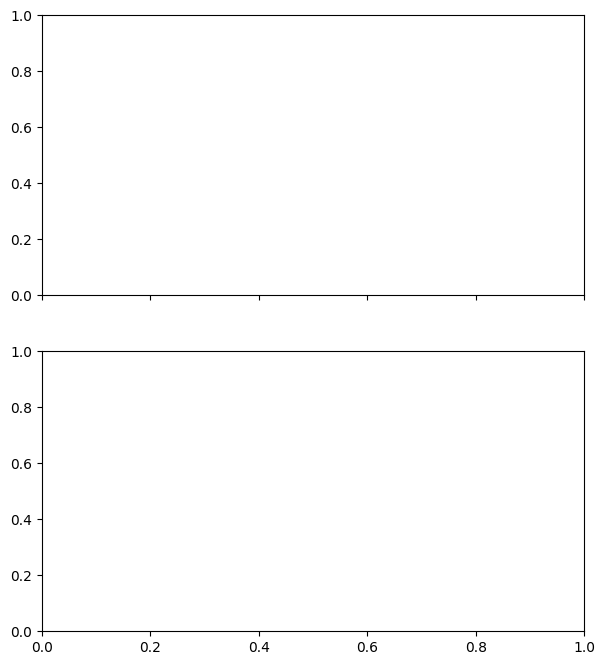

In [5]:
num_evs = 500000


save_str = 'Merit_Order/S6b_mef_vis_demand'
fig, axes = plt.subplots(2, 1, figsize=(7,8), sharex=True, sharey=False)
num_ev_set = [500000]
result_date = ['20231106']
run_number = ['0']
signal1 = 'varying'
signal2 = 'access'
groups = 5
for i in range(groups):
    results_gperkwh, df_controlled_dpdf, df_total_controlled, df_total_uncontrolled = results_gperkwh_fxn(num_ev_set, path_string, run_number[0], result_date[0], group_num=i)
    dpdf_inds = df_controlled_dpdf[signal1][signal2][num_evs][df_controlled_dpdf[signal1][signal2][num_evs].datetime.dt.date.isin(df_total_controlled[signal1][signal2][num_evs].datetime.dt.date.unique())].index
    axes[1] = emissions_mef_plot(df_controlled_dpdf, dpdf_inds, num_evs, save_str, axes[1], group_num=i)
    axes[0] = emissions_demand_plot(df_controlled_dpdf, df_total_uncontrolled, dpdf_inds, num_evs, save_str, axes[0], group_num=i)

plt.annotate('',
            xy=(.8, -.24), xycoords='axes fraction',
            xytext=(.18, -.24), textcoords='axes fraction', color=colorset[0], fontsize =16,
            arrowprops=dict(linewidth=5, color=colorset[0] ),
             ha='center',va='bottom')

plt.text(.45, -1.43,"Time",  transform=axes[0].transAxes, color=colorset[0], fontsize =18)
plt.savefig(save_str + '.pdf', bbox_inches='tight')
plt.show()
